In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
import monai
import sys
sys.path.append('./modified_medsam_repo')
from segment_anything import sam_model_registry
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob
import pandas as pd
import nibabel as nib
import pickle
import time
from PIL import Image
from MedSAM_HCP.dataset import MRIDataset_Imgs, load_datasets
from MedSAM_HCP.MedSAM import MedSAM
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.loss_funcs_hcp import *

In [4]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

In [ ]:
do
    srun -lN1 --mem=100G --gres=gpu:1 -c $SLURM_CPUS_ON_NODE -N 1 -n 1 -r $i bash -c \
    "python /gpfs/home/kn2347/MedSAM/train_multi_gpus_modified_multiclass.py \
        --data_frame_path /gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/path_df_pooled_labels_only_with_bbox_yolov7.csv \
        --df_desired_path /gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv \
        -train_test_splits /gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle \
        -task_name MedSAM_finetune_final_round \
        --wandb_run_name pooled_labels_yolov7 \
        -checkpoint /gpfs/home/kn2347/MedSAM/medsam_vit_b.pth \
        -work_dir /gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pool_model_rerun_8-26-23 \
        -label_id 1 \
        -batch_size 64 \
        -num_workers 4 \
        -num_epochs 30 \
        --lambda_dice 0 \
        -lr 1e-4 \
        -use_wandb True \
        -use_amp \
        --suppress_train_debug_imgs \
        --pool_labels \
        --world_size ${WORLD_SIZE} \
        --bucket_cap_mb 25 \
        --grad_acc_steps 1 \
        --node_rank ${i} \
        --init_method tcp://${MASTER_ADDR}:${MASTER_PORT}" >> ./logs/log_for_${SLURM_JOB_ID}_node_${i}.log 2>&1 &
done
wait ## Wait for the tasks on nodes to finish

In [119]:

class MRIDataset_Imgs(Dataset): 
    def __init__(self, data_frame, label_id=None, bbox_shift=0, label_converter=None, NUM_CLASSES = 256, as_one_hot = True, pool_labels = False, preprocess_fn=None):
        self.data_frame = data_frame
        self.bbox_shift = bbox_shift
        self.label_id = label_id
        self.label_converter = label_converter
        self.NUM_CLASSES = NUM_CLASSES
        self.as_one_hot = as_one_hot
        self.pool_labels = pool_labels
        self.preprocess_fn = preprocess_fn

        if self.label_converter is None:
            print('Initializing with no label converter, are you sure the labels are correct?')

        #if self.pool_labels and self.label_converter is not None: actually, will already come compressed
        #    self.data_frame['label_number'] = self.label_converter.hcp_to_compressed(self.data_frame['label_number'])
        #print(f'number of images: {data_frame.shape[0]}')
    
    def __len__(self):
        return self.data_frame.shape[0]

    def __getitem__(self, index):
        # load image as npy (256x256x3)
        img_path = self.data_frame.loc[index,'img_slice_path']
        img = Image.open(img_path)

        img_npy = np.array(img)

        if self.preprocess_fn is not None:
            img_npy = self.preprocess_fn(img_npy)
            
        img_npy = np.transpose(img_npy, axes = (2, 0, 1))



        #img_npy = np.load(img_path)
        
        # load segmentation mask as npy
        seg_path = self.data_frame.loc[index,'segmentation_slice_path']
        seg_npy = np.load(seg_path) # (256, 256)

        if self.label_converter is not None:
            seg_npy = self.label_converter.hcp_to_compressed(seg_npy)

        if self.label_id is not None:
           seg_npy = (seg_npy == self.label_id)

        # currently seg_npy is (H,W)
        seg_tens = torch.LongTensor(seg_npy[None, :, :]) # B, H, W
        seg_tens = torch.nn.functional.one_hot(seg_tens, num_classes=self.NUM_CLASSES) # B, H, W, C
        
        seg_tens = torch.permute(seg_tens, (0, 3, 1, 2)) # B, C, H, W
        seg_tens = seg_tens[0] # exclude batch dimension -> C, H, W
        # ignore 0th channel
        seg_tens = seg_tens[1:,:,:]



        '''
        if self.label_id is None: # use all classes
            # currently seg_npy is (H,W)
            seg_tens = torch.LongTensor(seg_npy[None, :, :]) # B, H, W
            seg_tens = torch.nn.functional.one_hot(seg_tens, num_classes=self.NUM_CLASSES) # B, H, W, C
            seg_tens = torch.permute(seg_tens, (0, 3, 1, 2)) # B, C, H, W
            seg_tens = seg_tens[0] # exclude batch dimension -> C, H, W
        '''

        ido = self.data_frame.loc[index,'id']
        sliceo = self.data_frame.loc[index,'slice']
        img_slice_name = f'{ido}_{sliceo}'

        return torch.tensor(img_npy).float(), seg_tens

# code to load train, val, test datasets
def load_datasets(path_df_path, train_test_splits_path, label_id, bbox_shift=0, 
                sample_n_slices = None, label_converter=None, NUM_CLASSES=256, 
                as_one_hot=True, pool_labels=False,
                preprocess_fn = None):
    # load dataframe of slice paths
    path_df = pd.read_csv(path_df_path)

    # load train val test ids
    dicto = pickle.load(open(train_test_splits_path, 'rb'))
    train_ids = dicto['train']
    val_ids = dicto['val']
    test_ids = dicto['test']

    train_df = path_df[path_df['id'].isin(train_ids)].reset_index(drop=True)
    val_df = path_df[path_df['id'].isin(val_ids)].reset_index(drop=True)
    test_df = path_df[path_df['id'].isin(test_ids)].reset_index(drop=True)

    train_dataset = MRIDataset_Imgs(train_df, label_id, bbox_shift, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=as_one_hot, pool_labels=pool_labels, preprocess_fn = preprocess_fn)
    val_dataset = MRIDataset_Imgs(val_df, label_id, 0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=as_one_hot, pool_labels=pool_labels, preprocess_fn = preprocess_fn)
    test_dataset = MRIDataset_Imgs(test_df, label_id, 0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=as_one_hot, pool_labels=pool_labels, preprocess_fn = preprocess_fn)

    return train_dataset, val_dataset, test_dataset


In [83]:
#path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/medsam/path_df_label1_only_with_bbox.csv'
path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
#train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = 2, bbox_shift=0, sample_n_slices = None)


path_df = pd.read_csv(path_df_path)


# load train val test ids
dicto = pickle.load(open(train_test_splits_path, 'rb'))
train_ids = dicto['train']
val_ids = dicto['val']
test_ids = dicto['test']

#train_df = path_df[path_df['id'].isin(train_ids)].reset_index(drop=True)
#val_df = path_df[path_df['id'].isin(val_ids)].reset_index(drop=True)
#test_df = path_df[path_df['id'].isin(test_ids)].reset_index(drop=True)


def modify_df(df, tr_type):
    assert tr_type in ['train', 'val', 'test']
    dfo = df
    listo = []
    seglisto = []
    for i, r in df.iterrows():    
        imgpath = os.path.join(f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/dir_structure_for_yolov7/{tr_type}/images',
                    f'{r.id}_slice{r.slice}.png')
        segpath = os.path.join(f'/gpfs/data/cbi/hcp/hcp_ya/hcp_ya_slices_npy/segmentation_slices', f'{r.id}', f'seg_{r.slice}.npy')
        listo.append(imgpath)
        seglisto.append(segpath)

    dfo['img_slice_path'] = listo
    dfo['segmentation_slice_path'] = seglisto
    dfo = dfo[['id', 'slice', 'img_slice_path', 'segmentation_slice_path']]
    return dfo

new_train = modify_df(train_df, 'train')
new_val = modify_df(val_df, 'val')
new_test = modify_df(test_df, 'test')

NameError: name 'train_df' is not defined

In [79]:
all_df = pd.concat([new_train, new_val, new_test])
all_df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv')

In [26]:
new_train.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/label1/train_df.csv')
new_val.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/label1/val_df.csv')
new_test.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/label1/test_df.csv')

## m

In [5]:
num_classes = 1
activation = 'sigmoid'
batch_sz = 256
label_id = 7
lr = 1e-4 * 32

In [6]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
label_converter = LabelConverter(df_hcp, df_desired)

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

train, val, test = load_datasets('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv',
            '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
            label_id = label_id, bbox_shift=0, 
                sample_n_slices = None, label_converter=label_converter, NUM_CLASSES=num_classes+1, 
                as_one_hot=True, pool_labels=False, preprocess_fn = preprocess_input,
                dataset_type = MRIDataset_Imgs)

train_loader = DataLoader(train, batch_size=batch_sz, shuffle=False, num_workers=0)
valid_loader = DataLoader(val, batch_size=batch_sz, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=batch_sz, shuffle=False, num_workers=0)

In [7]:
train[0][1].shape


torch.Size([1, 256, 256])

## Train Unet

In [8]:
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=num_classes,            # model output channels (number of classes in your dataset)
    activation = activation
).cuda()

In [70]:
xd = smp.utils.metrics.IoU(threshold=0.5)

In [9]:

it = iter(train_loader)
first = next(it)
zz = model(first[0].cuda())
print(zz.shape)
print(first[1].shape)

torch.Size([256, 1, 256, 256])
torch.Size([256, 1, 256, 256])


In [10]:
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.base import Loss


In [11]:
class dice_ce_loss(Loss):
    def __init__(self, lambda_dice = 1, **kwargs):
        super().__init__(**kwargs)
        self.lambda_dice = lambda_dice

    def forward(self, y_pred, y_true):
        # y_pred: (B, C, H, W)
        # y_true: (B, C, H, W)

        ce_loss = 0
        dice_loss = monai.losses.DiceLoss(include_background = True, sigmoid=False, squared_pred=True, reduction='mean',
            batch = True)
        return dice_loss(y_pred, y_true) * self.lambda_dice + ce_loss * (1-self.lambda_dice)

In [64]:
loss_dice_test = dice_ce_loss(lambda_dice = 1)

test_y_gt = torch.zeros((64, 1, 256, 256))
test_y_gt[0, 0, 45, 45] = 1
test_y_pred = torch.ones((64, 1, 256, 256)) * 0.001
test_y_pred[0,0,45,45] = 1
#loss.forward(test_y_pred, test_y_gt)
loss_dice_test.forward(test_y_pred, test_y_gt)

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/monai/losses/dice.py:153: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")


tensor(0.6771)

In [12]:
#loss = DiceLoss()
loss = dice_ce_loss(lambda_dice = 1)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=lr),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device='cuda',
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

In [14]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/test_label7_singletask_unet_testing_5-26-24/best_model.pth')
        print('Model saved!')
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/375 [00:00<?, ?it/s]

valid: 100%|██████████| 47/47 [11:25<00:00, 14.59s/it, dice_ce_loss - 0.09295, iou_score - 0.832] 
Model saved!

Epoch: 1
valid: 100%|██████████| 47/47 [09:04<00:00, 11.59s/it, dice_ce_loss - 0.085, iou_score - 0.8473]  
Model saved!

Epoch: 2
valid: 100%|██████████| 47/47 [09:13<00:00, 11.78s/it, dice_ce_loss - 0.08195, iou_score - 0.8529]
Model saved!

Epoch: 3
valid: 100%|██████████| 47/47 [08:36<00:00, 10.99s/it, dice_ce_loss - 0.08059, iou_score - 0.8559]
Model saved!

Epoch: 4
valid: 100%|██████████| 47/47 [10:21<00:00, 13.23s/it, dice_ce_loss - 0.07962, iou_score - 0.8576]
Model saved!

Epoch: 5
valid: 100%|██████████| 47/47 [07:51<00:00, 10.03s/it, dice_ce_loss - 0.07902, iou_score - 0.8589]
Model saved!

Epoch: 6
valid: 100%|██████████| 47/47 [07:44<00:00,  9.89s/it, dice_ce_loss - 0.07839, iou_score - 0.8602]
Model saved!

Epoch: 7
valid: 100%|██████████| 47/47 [07:40<00:00,  9.81s/it, dice_ce_loss - 0.07804, iou_score - 0.8612]
Model saved!

Epoch: 8
valid: 100%|██████████| 

KeyboardInterrupt: 

## Calculate output metrics

In [11]:
path_label1 = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_singletask_testing_5-26-24/best_model.pth'


'''
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=num_classes,            # model output channels (number of classes in your dataset)
    activation = activation
)

model.load_state_dict(torch.load(path_label1))
model.eval()

'''

model = torch.load(path_label1)
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [79]:
torch.where(first[1][:,1,:,:] == 1)

(tensor([ 42,  42,  42,  ..., 255, 255, 255]),
 tensor([141, 141, 142,  ..., 143, 143, 143]),
 tensor([139, 140, 133,  ..., 134, 135, 136]))

torch.Size([1, 3, 256, 256])
torch.Size([1, 256, 256])


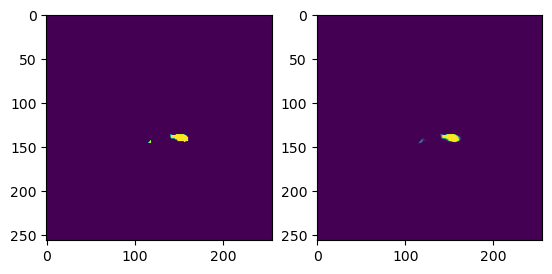

In [15]:
it = iter(test_loader)
first = next(it)

idx = 50
imgo = first[0][idx:idx+1,:,:,:]
seg = first[1][idx:idx+1,0,:,:]

fig, axs = plt.subplots(1,2)

axs[0].imshow(np.squeeze(seg))

print(imgo.shape)
pred = model(imgo.cuda())[:,0,:,:]
print(pred.shape)
            
axs[1].imshow(np.squeeze(pred.cpu().detach().numpy()))

#zz = model(first[0])
#print(zz.shape)
#print(first[1].shape)

In [ ]:
model

In [33]:
from torchsummary import summary

In [35]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [36]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,